In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

import math

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aashishpatel","key":"d1f9de0ad4f74c0df5d828f9e6a73ee5"}'}

In [ ]:
% ls

drive/  kaggle.json  sample_data/


In [ ]:
% mkdir ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle datasets download -d pdavpoojan/the-rvlcdip-dataset-test

100% 3.61G/3.62G [01:07<00:00, 28.8MB/s]
100% 3.62G/3.62G [01:07<00:00, 57.8MB/s]


In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
% mkdir train

In [ ]:
## to delete the whole directory
##import shutil
##shutil.rmtree('/content/kaggle/test')

In [ ]:
! unzip /content/the-rvlcdip-dataset-test.zip -d /content/train

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/test/scientific_publication/PUBLICATIONS040137-0.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS041468-1.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS041570-1.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS041737-1.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS042046-2.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS042251A-.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS042455-2.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS044016-4.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS044594-4.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS044641-4.tif  
  inflating: /content/train/test/scientific_publication/PUBLICATIONS044730-4.tif  
  inflating: /content/train/test/sci

In [ ]:
import cv2
for dirname, _, filenames in os.walk("/content/train/test/"):
    for filename in filenames:
        if not hasattr(cv2.imread(os.path.join(dirname, filename)), "shape"):
            os.remove(os.path.join(dirname,filename))

In [ ]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 50
# name of the dataset
dataset_path = "/content/train/test/"
# size of the batches
batch_size = 64
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 64
# high res. image width
hr_width = 64
# number of image channels
channels = 1

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

In [ ]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                #transforms.Resize(())
                transforms.CenterCrop((hr_height, hr_width)),
                transforms.Resize((hr_height//2, hr_width//2)),
                ##transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                ##transforms.Normalize(mean[0], std[0]),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.CenterCrop((hr_height, hr_width)),
               ## transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                ##transforms.Normalize(mean[0], std[0]),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [ ]:
#### combining all the folders into one

In [ ]:
train_path = []
from pathlib import Path
for path in Path(dataset_path).rglob("*.tif"):
    train_path.append(path)

# test_paths = []
# from pathlib import Path
# for path in Path(dataset_path).rglob("*.tif"):
#     train_paths.append(path)

In [ ]:
train_paths, test_paths = train_test_split(train_path, test_size=0.02, random_state=42)
#train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.*")), test_size=0.02, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True, num_workers=n_cpu)

In [ ]:
len(train_paths)

39196

In [ ]:
len(test_paths)

800

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])
        
        for name, param in self.feature_extractor.named_parameters():
            param.requires_grad = False

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(1):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                ## so if you run the loop n times then 2^n upsampling of image will be achieved
                ## so for 2^n HR image, run the loop 'n' times.
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape, SR_factor=2):
        super(Discriminator, self).__init__()

        self.SR_factor = int(math.log(SR_factor,2))##log base 2
        print(self.SR_factor)
        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** self.SR_factor), int(in_width / 2 ** self.SR_factor)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        what_to_enumerate=[]
        for i in range(self.SR_factor):
          what_to_enumerate.append(64*(i+1))
        ##what_to_enumerate = [64, 128, 256, 512]
        ### downsampling to (1/(2^n)) requires 'n' elements in the what_to_enumerate list
        for i, out_filters in enumerate(what_to_enumerate):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [ ]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Load pretrained models
#if load_pretrained_models:
#    generator.load_state_dict(torch.load("../input/single-image-super-resolution-gan-srgan-pytorch/saved_models/generator.pth"))
#    discriminator.load_state_dict(torch.load("../input/single-image-super-resolution-gan-srgan-pytorch/saved_models/discriminator.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

1


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
#generator(torch.randn(64,1,32,32)).shape

In [ ]:
#discriminator(torch.randn(64,1,64,64)).shape

In [ ]:
### if what_to_enumrate is passed fully into the discriminator, then the input to the discriminator is upsampled by 4 times, as it block upsamples by a factor of 2

In [ ]:

# import torch
# import shutil
# # def save_ckp(state, checkpoint_dir):
# #     f_path = checkpoint_dir / 'checkpoint.pt'
# #     torch.save(state, f_path)
# #     if is_best:
# #         best_fpath = best_model_dir / 'best_model.pt'
# #         shutil.copyfile(f_path, best_fpath)

# checkpoint = {
#     'epoch': epoch + 1,
#     'state_dict': model.state_dict(),
#     'optimizer': optimizer.state_dict()
# }
# save_ckp(checkpoint, is_best, checkpoint_dir, model_dir)

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/SRGAN WEIGHTS 64x64 to 128x128/checkpt30.pt",map_location=torch.device('cpu'))
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

generator.train()
discriminator.train()

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]

for epoch in range(31,n_epochs):

    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); discriminator.train()

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)


        # Content loss
        # converting the 1 channel input image to 3 channel input image, with the last two channels containing zero
        gen_hr_3 = gen_hr.repeat_interleave(3, dim=1)
        gen_hr_3[:,1:3,:,:]=0 ## first dimension is for batch_size, second for channesls, and the last two for feature map
        ##gen_hr_3[]
        imgs_hr_3 = imgs_hr.repeat_interleave(3, dim=1)
        imgs_hr_3[:,1:3,:,:] = 0

        
        
        gen_features = feature_extractor(gen_hr_3)
        real_features = feature_extractor(imgs_hr_3)
        loss_content = criterion_content(gen_features, real_features.detach())##detached because no backprop in VGG
        
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

    # Testing
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.eval(); discriminator.eval()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        ### Eval Generator
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        
        # Content loss
        # converting the 1 channel input image to 3 channel input image, with the last two channels containing zero
        gen_hr_3 = gen_hr.repeat_interleave(3, dim=1)
        gen_hr_3[:,1:3,:,:]=0 ## first dimension is for batch_size, second for channesls, and the last two for feature map
        ##gen_hr_3[]
        imgs_hr_3 = imgs_hr.repeat_interleave(3, dim=1)
        imgs_hr_3[:,1:3,:,:] = 0
        
        gen_features = feature_extractor(gen_hr_3)
        real_features = feature_extractor(imgs_hr_3)
        loss_content = criterion_content(gen_features, real_features.detach())## real_features is detached because VGG which we are using here is 
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        ### Eval Discriminator
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        gen_loss += loss_G.item()
        disc_loss += loss_D.item()
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))
        
        # Save image grid with upsampled inputs and SRGAN outputs
        # if random.uniform(0,1)<0.1:
        #     imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
        #     imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
        #     gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
        #     imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
        #     img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
        #     save_image(img_grid, f"images/{batch_idx}.png", normalize=False)

    test_gen_losses.append(gen_loss/len(test_dataloader))
    test_disc_losses.append(disc_loss/len(test_dataloader))
    

    if((epoch+1)%5 == 0 or epoch==0):
      # torch.save({
      #       'epoch': epoch+1,
      #       'generator_state_dict': generator.state_dict(),
      #       'optimizer_state_dict': optimizer_G.state_dict(),
      #       'loss': loss,
      #       ...
      #       }, PATH)

      # torch.save({
      #       'epoch': epoch+1,
      #       'discriminator_state_dict': discriminator.state_dict(),
      #       'optimizer_state_dict': optimizer.state_dict(),
      #       'loss': loss,
      #       ...
      #       }, PATH)
      torch.save({
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_state_dict': generator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'epoch': epoch+1,
            }, "/content/drive/MyDrive/SRGAN WEIGHTS 64x64 to 128x128/checkpt{}.pt".format(epoch+1))
      #torch.save(model.state_dict(), 'train_valid_exp4-epoch{}.pth'.format(epoch))
      #torch.save(generator.state_dict(), "/content/drive/MyDrive/SRGAN WEIGHTS/generator{}.pth".format(epoch+1))
      #torch.save(discriminator.state_dict(), "/content/drive/MyDrive/SRGAN WEIGHTS/discriminator{}.pth".format(epoch+1))
    # # Save model checkpoints
    # if np.argmin(test_gen_losses) == len(test_gen_losses)-1:
    #     torch.save(generator.state_dict(), "saved_models/generator.pth")
    #     torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")
        

KeyboardInterrupt: ignored

In [ ]:
# gen_hr: 32x1x64x64
# discriminator(gen_hr): 32x1x32x32 
# valid: 32x1x32x32
# imgs_lr: 32x1x32x32
# imgs_hr: 32x1x64x64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

In [ ]:
print(gen_hr_3[0][0][:][:].shape)

torch.Size([64, 64])


In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/SRGAN WEIGHTS 64x64 to 128x128/checkpt30.pt",map_location=torch.device('cpu'))
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

generator.eval()
# modelB.eval()
# # - or -
# modelA.train()
# modelB.train()

GeneratorResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps

In [ ]:
! unzip /content/input.zip -d /content/data

Archive:  /content/input.zip
  inflating: /content/data/155.png   
  inflating: /content/data/156.png   
  inflating: /content/data/99.png    
  inflating: /content/data/100.png   
  inflating: /content/data/130.png   


In [ ]:
% mkdir super_resolved_8x

In [ ]:
import re
num = re.compile('\d{1,9}')

In [ ]:
## loop to process all images in the handwritten folder
from PIL import Image, ImageOps
count=10;
trans1 = transforms.ToTensor()
from pathlib import Path
for path in Path('/content/data').rglob("*.png"):
    #train_path_hr.append(path)
    #print(str(path))
    img_orig = ImageOps.grayscale(Image.open(str(path)))
    img_SR = generator(trans1(img_orig).unsqueeze(1))
    index = num.findall(str(path).split('/')[-1])[0]
    save_image(img_SR.squeeze(0).squeeze(0).cpu().detach(), f'/content/super_resolved_2x/{index}_reconstructed.png')

In [ ]:
! zip -r /content/super_resolved_8x.zip /content/super_resolved_8x

  adding: content/super_resolved_8x/ (stored 0%)
  adding: content/super_resolved_8x/130_reconstructed.png (deflated 2%)
  adding: content/super_resolved_8x/99_reconstructed.png (deflated 1%)
  adding: content/super_resolved_8x/155_reconstructed.png (deflated 2%)
  adding: content/super_resolved_8x/156_reconstructed.png (deflated 1%)
  adding: content/super_resolved_8x/100_reconstructed.png (deflated 2%)


In [ ]:
from torchvision.utils import save_image

from PIL import Image, ImageOps
import torch
import torchvision
from torchvision.transforms import ToTensor, Scale, Compose
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
% mkdir data

In [ ]:
! unzip /content/drive/MyDrive/char_level_shubh_Dataset/char_level_1.zip -d /images

Archive:  /content/drive/MyDrive/char_level_shubh_Dataset/char_level_1.zip
   creating: /images/char_level/
 extracting: /images/char_level/41.png  
 extracting: /images/char_level/8.png  
 extracting: /images/char_level/34.png  
 extracting: /images/char_level/36.png  
 extracting: /images/char_level/11.png  
 extracting: /images/char_level/14.png  
 extracting: /images/char_level/15.png  
 extracting: /images/char_level/4.png  
 extracting: /images/char_level/40.png  
 extracting: /images/char_level/5.png  
 extracting: /images/char_level/24.png  
 extracting: /images/char_level/25.png  
  inflating: /images/char_level/31.png  
 extracting: /images/char_level/33.png  
 extracting: /images/char_level/39.png  
 extracting: /images/char_level/9.png  
 extracting: /images/char_level/27.png  
 extracting: /images/char_level/22.png  
 extracting: /images/char_level/35.png  
 extracting: /images/char_level/6.png  
 extracting: /images/char_level/7.png  
 extracting: /images/char_level/12.pn

In [ ]:
y% mkdir results

In [ ]:
from os import walk

_, _, filenames = next(walk('/images/char_level'))

In [ ]:
len(filenames)

42

In [ ]:
img_path = []
from pathlib import Path
for path in Path('/images/char_level').rglob("*.png"):
    img_path.append(path)

print(len(img_path))
count=1
for path in img_path:
  count+=1
  img_orig = ImageOps.grayscale(Image.open(str(path)))
  trans1 = transforms.ToTensor()
  save_image(trans1(img_orig), f'/content/results/lr_img{count}.png')
  img_sr = generator(trans1(img_orig).unsqueeze(1))
  sr_img = img_sr.squeeze(0).squeeze(0).detach()
  save_image(sr_img, f'/content/results/sr_img{count}.png')


41


In [ ]:
! zip -r results.zip /content/results

updating: content/results/ (stored 0%)
  adding: content/results/lr_img36.png (stored 0%)
  adding: content/results/sr_img27.png (stored 0%)
  adding: content/results/sr_img7.png (deflated 0%)
  adding: content/results/lr_img5.png (stored 0%)
  adding: content/results/sr_img15.png (deflated 1%)
  adding: content/results/lr_img26.png (stored 0%)
  adding: content/results/sr_img4.png (stored 0%)
  adding: content/results/lr_img32.png (stored 0%)
  adding: content/results/lr_img23.png (stored 0%)
  adding: content/results/lr_img9.png (stored 0%)
  adding: content/results/sr_img14.png (deflated 1%)
  adding: content/results/lr_img39.png (stored 0%)
  adding: content/results/sr_img35.png (stored 0%)
  adding: content/results/sr_img24.png (deflated 0%)
  adding: content/results/sr_img22.png (stored 0%)
  adding: content/results/sr_img13.png (deflated 1%)
  adding: content/results/sr_img2.png (deflated 3%)
  adding: content/results/lr_img3.png (stored 0%)
  adding: content/results/sr_img8.png

shape of original image is  torch.Size([1, 12, 18])
shape of Lr ==  torch.Size([1, 256, 256])


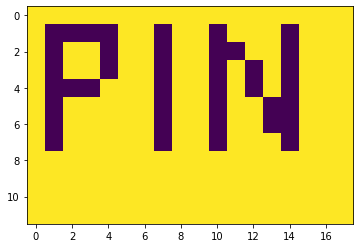

In [ ]:
## input a random text image to the generator by cropping it and converting to torch tensor
from PIL import Image, ImageOps
img_path = '/content/data/156.png'
img_orig = ImageOps.grayscale(Image.open(img_path))
trans1 = transforms.ToTensor()
trans2 = transforms.RandomCrop((256, 256))
trans3 = transforms.Resize((1024,1024),Image.BILINEAR)

print("shape of original image is ",trans1(img_orig).shape)### shape of the original image in tensor form

img_LR = trans2(trans3(img_orig))

save_image(trans1(img_LR),"lr_5.png")
plt.imshow(img_orig)
print("shape of Lr == ",trans1(img_LR).shape)
#LR_tensor = trans1(img_LR)

In [ ]:
## Pass the above image to generator to Super Resolve it
img_SR = generator(trans1(img_orig).unsqueeze(1)) ## adding one channel to the end image at the 1 index [batch_size,channels, height, width]

In [ ]:
img_SR.squeeze(0).squeeze(0).unsqueeze(2).shape

torch.Size([24, 36, 1])

torch.Size([24, 36])


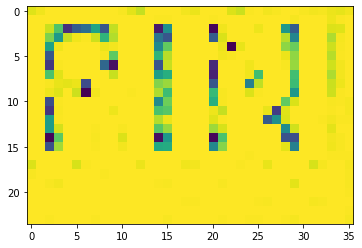

In [ ]:
sr_img = img_SR.squeeze(0).squeeze(0).detach()
print(sr_img.shape)
save_image(sr_img,"sr_5.png")
plt.imshow(sr_img.numpy())

torch.Size([1, 12, 18])
12 18


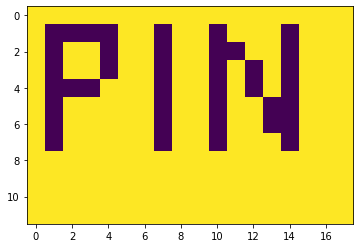

In [ ]:
#### Now I will try to break the image, when both the images are in tensor form only
## divide imt_orig into four
imt_orig = trans1(img_orig)
print(imt_orig.shape)
plt.imshow(imt_orig[0].detach().numpy())
m = (imt_orig.shape)[1] ## no of rows
n = (imt_orig.shape)[2] ## no of columns
print(m,n)

32 32


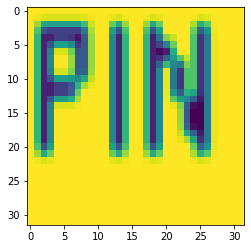

In [ ]:
## resize the image according to the
f = 32
trans4 = transforms.Resize((max(32,(m//f)*f),max(32,(n//f)*f)))
imt_orig = trans4(imt_orig)
m = (imt_orig.shape)[1] ## no of rows
n = (imt_orig.shape)[2] ## no of columns
plt.imshow(imt_orig.squeeze(0))
print(m,n)

In [ ]:
#def divide_images_into_MxN_grid_with_indexes():


In [ ]:
### Now dividing the image
### all the images are in tensor form
image_index = []
SR_image_index = []
for i in range(m//f):
  for j in range(n//f):
    image_patch = imt_orig[0][i*32:(i+1)*(32), j*(32):(j+1)*(32)]
    image_index.append(image_patch)
    SR_patch = generator(image_patch.unsqueeze(0).unsqueeze(0))
    SR_image_index.append(SR_patch.squeeze(0).squeeze(0).detach().cpu())

In [ ]:
len(image_index)

1

In [ ]:
len(SR_image_index)

1

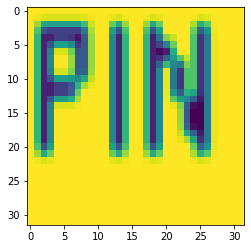

In [ ]:
plt.imshow(image_index[0])
## mission successful

In [ ]:
print(image_index[0].shape)
    

torch.Size([32, 32])


In [ ]:
print(SR_image_index[0].shape)

torch.Size([64, 64])


In [ ]:
plt.imshow(SR_image_index[56])

IndexError: ignored

In [ ]:
#### stiching back the super resolved parts of image into one
SR_m = m*2
SR_n = n*2
c=0;
SR_final_image = torch.zeros((SR_m,SR_n))
for i in range(m//f):
  for j in range(n//f):
    SR_final_image[i*(64):(i+1)*(64), j*(64):(j+1)*(64)] = SR_image_index[c]
    c+=1

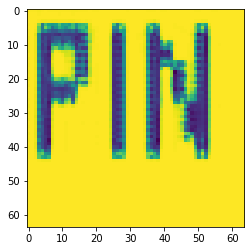

In [ ]:
plt.imshow(SR_final_image)


In [ ]:
C=2

In [ ]:
## saving the two images
save_image(SR_final_image,"SR_{}.png".format(C))
save_image(imt_orig,"LR_{}.png".format(C))
C+=1

In [ ]:
C=7

In [ ]:
import re
num = re.compile('\w{1,}')
s = "guhtu113_.jpg"
print(num.findall(s.split('/')[-1])[0])

guhtu113_


In [ ]:
from PIL import Image, ImageOps
import re
num = re.compile('\w{1,}')
def resize_snip_super_resolve_patch(path_to_image, destination_folder_path):
  path_to_image = str(path_to_image)

  img_path = path_to_image   #'/content/data/156.png'
  img_orig = ImageOps.grayscale(Image.open(img_path))
  trans1 = transforms.ToTensor()
  imt_orig= trans1(img_orig)

  (_, m, n) = imt_orig.shape

  ## resizing image
  f = 32
  trans4 = transforms.Resize((max(32,(m//f)*f),max(32,(n//f)*f)))
  imt = trans4(imt_orig)

  (_, m, n) = imt.shape

  ## snipping and super-resolving

  image_index = []
  SR_image_index = []
  for i in range(m//f):
    for j in range(n//f):
      image_patch = imt[0][i*32:(i+1)*(32), j*(32):(j+1)*(32)]
      image_index.append(image_patch)
      SR_patch = generator(image_patch.unsqueeze(0).unsqueeze(0))
      SR_image_index.append(SR_patch.squeeze(0).squeeze(0).detach().cpu())

  ## patching the super-resolved parts

  SR_m = m*2
  SR_n = n*2
  
  c=0
  SR_final_image = torch.zeros((SR_m,SR_n))
  
  for i in range(m//f):
    for j in range(n//f):
      SR_final_image[i*(64):(i+1)*(64), j*(64):(j+1)*(64)] = SR_image_index[c]
      c+=1


  index = num.findall(path_to_image.split('/')[-1])[0]
  ## saving both the super-resolved and original images in one folder
  save_image(SR_final_image,destination_folder_path+"/SR_{}.png".format(index))
  save_image(imt,destination_folder_path+"/LR_{}.png".format(index))



In [ ]:
## testing the above script
resize_snip_super_resolve_patch('/content/130.png')

In [ ]:
! unzip /content/input.zip -d /content/data

Archive:  /content/input.zip
  inflating: /content/data/155.png   
  inflating: /content/data/156.png   
  inflating: /content/data/99.png    
  inflating: /content/data/100.png   
  inflating: /content/data/130.png   


In [ ]:
## combining the snip-patch script and the folder script
from pathlib import Path

def process_images(dataset_path, destination_folder):
  #! unzip source_zip -d /content/lr_data
  dataset_path = dataset_path#'/content/lr_data' #'/content/data'
  
  
  image_type = 'png'
  img_path = []
  for path in Path(dataset_path).rglob(f'*.{image_type}'):
    img_path.append(path)


  #! mkdir /content/sr_data
  
  #destination_folder = '/content/sr_data'
  for path in img_path:
    resize_snip_super_resolve_patch(path, destination_folder)

  #!zip -r destination_zip_name destination_folder


process_images('/content/char_sr_4x/', '/content/char_sr_8x/')

In [ ]:
% mkdir char_sr_8x

In [ ]:
! unzip /content/drive/MyDrive/char_level_shubh_Dataset/char_level_1.zip -d /content/char_data

Archive:  /content/drive/MyDrive/char_level_shubh_Dataset/char_level_1.zip
   creating: /content/char_data/char_level/
 extracting: /content/char_data/char_level/41.png  
 extracting: /content/char_data/char_level/8.png  
 extracting: /content/char_data/char_level/34.png  
 extracting: /content/char_data/char_level/36.png  
 extracting: /content/char_data/char_level/11.png  
 extracting: /content/char_data/char_level/14.png  
 extracting: /content/char_data/char_level/15.png  
 extracting: /content/char_data/char_level/4.png  
 extracting: /content/char_data/char_level/40.png  
 extracting: /content/char_data/char_level/5.png  
 extracting: /content/char_data/char_level/24.png  
 extracting: /content/char_data/char_level/25.png  
  inflating: /content/char_data/char_level/31.png  
 extracting: /content/char_data/char_level/33.png  
 extracting: /content/char_data/char_level/39.png  
 extracting: /content/char_data/char_level/9.png  
 extracting: /content/char_data/char_level/27.png  
 

In [ ]:
! zip -r char_sr_2x.zip char_sr_2x

  adding: char_sr_2x/ (stored 0%)
  adding: char_sr_2x/SR_16.png (deflated 1%)
  adding: char_sr_2x/LR_25.png (stored 0%)
  adding: char_sr_2x/LR_21.png (stored 0%)
  adding: char_sr_2x/SR_2.png (deflated 1%)
  adding: char_sr_2x/SR_10.png (deflated 0%)
  adding: char_sr_2x/SR_9.png (deflated 0%)
  adding: char_sr_2x/SR_18.png (deflated 0%)
  adding: char_sr_2x/LR_11.png (stored 0%)
  adding: char_sr_2x/LR_9.png (stored 0%)
  adding: char_sr_2x/LR_28.png (stored 0%)
  adding: char_sr_2x/LR_2.png (stored 0%)
  adding: char_sr_2x/LR_22.png (stored 0%)
  adding: char_sr_2x/LR_31.png (stored 0%)
  adding: char_sr_2x/SR_5.png (deflated 1%)
  adding: char_sr_2x/LR_13.png (stored 0%)
  adding: char_sr_2x/LR_23.png (stored 0%)
  adding: char_sr_2x/LR_6.png (stored 0%)
  adding: char_sr_2x/LR_17.png (stored 0%)
  adding: char_sr_2x/LR_5.png (stored 0%)
  adding: char_sr_2x/LR_29.png (stored 0%)
  adding: char_sr_2x/SR_33.png (deflated 1%)
  adding: char_sr_2x/SR_41.png (deflated 1%)
  adding: c

In [ ]:
def test():
  ! unzip /content/input.zip -d /content/data

In [ ]:
test()

Archive:  /content/input.zip
replace /content/data/155.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from pathlib import Path
for path in Path('/images/char_level').rglob("*.png"):
    img_path.append(path)

print(len(img_path))
count=1
for path in img_path:
  count+=1
  img_orig = ImageOps.grayscale(Image.open(str(path)))
  trans1 = transforms.ToTensor()
  save_image(trans1(img_orig), f'/content/results/lr_img{count}.png')
  img_sr = generator(trans1(img_orig).unsqueeze(1))
  sr_img = img_sr.squeeze(0).squeeze(0).detach()
  save_image(sr_img, f'/content/results/sr_img{count}.png')

In [ ]:
### to check against the result of bilinear interpolation adn bicubic interpolation


In [ ]:
# img1 = sr_img.unsqueeze(0).numpy()
# img2 = trans1(img_temp_rand).numpy()
# #np.append(img1,values=img2,axis=0,)
# vis = np.concatenate((img1, img2), axis=0)
# # final_image=np.empty((256+512,256+512))
# final_image[0:256][0:256] = img2
# final_image[256:512+256,256:256+512] = img1

In [ ]:
# import numpy 
# import math
# import cv2
# original = cv2.imread("original.png")
# contrast = cv2.imread("photoshopped.png",1)
# def psnr(img1, img2):
#     mse = numpy.mean( (img1 - img2) ** 2 )
#     if mse == 0:
#     return 100
#     PIXEL_MAX = 255.0
#     return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# d=psnr(original,contrast)
# print(d)

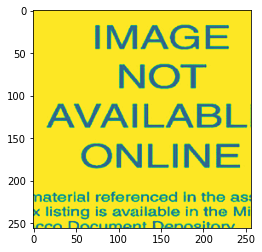

In [ ]:
# for i in range(5):
#   img_temp_rand = trans2(trans3(img_temp))
#   plt.imshow(img_temp_rand)
#   img_temp_SR = generator(trans1(img_temp_rand).unsqueeze(0))
#   plt.imshow(img_temp_SR.squeeze(0).squeeze(0).detach().numpy())

TypeError: ignored

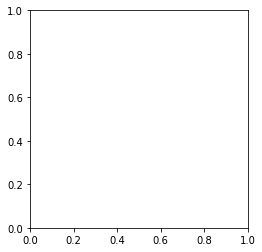

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(gen_hr_3[0].cpu().detach().numpy())

In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt



# from matplotlib.pyplot import figure
# figure(figsize=(18, 16), dpi=80)

# im = Image.open("/content/kaggle/train/test/specification/91351691.tif")
# plt.imshow(im, cmap="gray")

FileNotFoundError: ignored

<Figure size 1440x1280 with 0 Axes>

In [ ]:
# from torchvision.transforms import ToTensor
# t = ToTensor()
# imt = t(im)
# imt.shape

torch.Size([1, 1000, 777])

In [ ]:
import cv2

In [ ]:
# img = cv2.imread('/content/kaggle/train/test/specification/91351691.tif')
# img_resized = cv2.resize(img, (512,512), interpolation=cv2.INTER_CUBIC)
# figure(figsize=(18, 16), dpi=80)
# plt.imshow(img_resized, cmap="gray")

In [ ]:
# temp = [1,2,3,]
# print(temp[1:2])

[2]
